#Tutorial 5 - DQN

Please follow this tutorial to understand the structure (code) of DQN algorithm.


### References:

Please follow [Human-level control through deep reinforcement learning](https://www.nature.com/articles/nature14236) for the original publication as well as the psuedocode. Watch Prof. Ravi's lectures on moodle or nptel for further understanding of the core concepts. Contact the TAs for further resources if needed.


In [1]:
'''
Installing packages for rendering the game on Colab
'''

!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install git+https://github.com/tensorflow/docs > /dev/null 2>&1
!pip install gym[classic_control]

In [2]:
'''
A bunch of imports, you don't have to worry about these
'''

import numpy as np
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import namedtuple, deque
import torch.optim as optim
import datetime
import gym
from gym.wrappers.record_video import RecordVideo
import glob
import io
import base64
import matplotlib.pyplot as plt
from IPython.display import HTML
from pyvirtualdisplay import Display
import tensorflow as tf
from IPython import display as ipythondisplay
from PIL import Image
import tensorflow_probability as tfp

/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


In [3]:
'''
Please refer to the first tutorial for more details on the specifics of environments
We've only added important commands you might find useful for experiments.
'''

'''
List of example environments
(Source - https://gym.openai.com/envs/#classic_control)

'Acrobot-v1'
'Cartpole-v1'
'MountainCar-v0'
'''

env = gym.make('CartPole-v1')
env.seed(0)

state_shape = env.observation_space.shape[0]
no_of_actions = env.action_space.n

print(state_shape)
print(no_of_actions)
print(env.action_space.sample())
print("----")

'''
# Understanding State, Action, Reward Dynamics

The agent decides an action to take depending on the state.

The Environment keeps a variable specifically for the current state.
- Everytime an action is passed to the environment, it calculates the new state and updates the current state variable.
- It returns the new current state and reward for the agent to take the next action

'''

state = env.reset()
''' This returns the initial state (when environment is reset) '''

print(state)
print("----")

action = env.action_space.sample()
''' We take a random action now '''

print(action)
print("----")

next_state, reward, done, info = env.step(action)
''' env.step is used to calculate new state and obtain reward based on old state and action taken  '''

print(next_state)
print(reward)
print(done)
print(info)
print("----")


4
2
1
----
[ 0.01369617 -0.02302133 -0.04590265 -0.04834723]
----
0
----
[ 0.01323574 -0.21745604 -0.04686959  0.22950698]
1.0
False
{}
----


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym

## DQN

Using NNs as substitutes isn't something new. It has been tried earlier, but the 'human control' paper really popularised using NNs by providing a few stability ideas (Q-Targets, Experience Replay & Truncation). The 'Deep-Q Network' (DQN) Algorithm can be broken down into having the following components.

### Q-Network:
The neural network used as a function approximator is defined below

In [4]:
'''
### Q Network & Some 'hyperparameters'

QNetwork1:
Input Layer - 4 nodes (State Shape) \
Hidden Layer 1 - 128 nodes \
Hidden Layer 2 - 64 nodes \
Output Layer - 2 nodes (Action Space) \
Optimizer - zero_grad()
'''

import torch
import torch.nn as nn
import torch.nn.functional as F


'''
Bunch of Hyper parameters (Which you might have to tune later)
'''
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
LR = 5e-4               # learning rate
UPDATE_EVERY = 20       # how often to update the network (When Q target is present)


class QNetwork1(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=128, fc2_units=64):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(QNetwork1, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)

    def forward(self, state):
        """Build a network that maps state -> action values."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### Replay Buffer:

Recall why we use such a technique.

In [5]:
import random
import torch
import numpy as np
from collections import deque, namedtuple

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.

        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)

    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)

    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

## Tutorial Agent Code:


In [6]:
class TutorialAgent():

    def __init__(self, state_size, action_size, seed):

        ''' Agent Environment Interaction '''
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)

        ''' Q-Network '''
        self.qnetwork_local = QNetwork1(state_size, action_size, seed).to(device)
        self.qnetwork_target = QNetwork1(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)

        ''' Replay memory '''
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)

        ''' Initialize time step (for updating every UPDATE_EVERY steps)           -Needed for Q Targets '''
        self.t_step = 0

    def step(self, state, action, reward, next_state, done):

        ''' Save experience in replay memory '''
        self.memory.add(state, action, reward, next_state, done)

        ''' If enough samples are available in memory, get random subset and learn '''
        if len(self.memory) >= BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

        """ +Q TARGETS PRESENT """
        ''' Updating the Network every 'UPDATE_EVERY' steps taken '''
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:

            self.qnetwork_target.load_state_dict(self.qnetwork_local.state_dict())

    def act(self, state, eps=None, tau=None, policy=None):

        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        if policy == 'epsilon-greedy':
            ''' Epsilon-greedy action selection (Already Present) '''
            if random.random() > eps:
                return np.argmax(action_values.cpu().data.numpy())
            else:
                return random.choice(np.arange(self.action_size))

        elif policy == 'softmax':
            ''' Softmax action selection '''
            action_values_reduced = action_values.cpu().data.numpy() - np.max(action_values.cpu().data.numpy())
            p = np.exp(action_values_reduced/tau) / np.sum(np.exp(action_values_reduced/tau))

            return np.random.choice(np.prod(action_values_reduced.shape), p=p.flatten())

        else:
            print('Unknown policy.')


    def learn(self, experiences, gamma):
        """ +E EXPERIENCE REPLAY PRESENT """
        states, actions, rewards, next_states, dones = experiences

        ''' Get max predicted Q values (for next states) from target model'''
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        ''' Compute Q targets for current states '''
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        ''' Get expected Q values from local model '''
        Q_expected = self.qnetwork_local(states).gather(1, actions)

        ''' Compute loss '''
        loss = F.mse_loss(Q_expected, Q_targets)

        ''' Minimize the loss '''
        self.optimizer.zero_grad()
        loss.backward()

        ''' Gradiant Clipping '''
        """ +T TRUNCATION PRESENT """
        for param in self.qnetwork_local.parameters():
            param.grad.data.clamp_(-1, 1)

        self.optimizer.step()

### Here, we present the DQN algorithm code.

Episode 100	Average Score: 40.87
Episode 200	Average Score: 145.77
Episode 249	Average Score: 195.45
Environment solved in 249 episodes!	Average Score: 195.45
0:01:27.044289


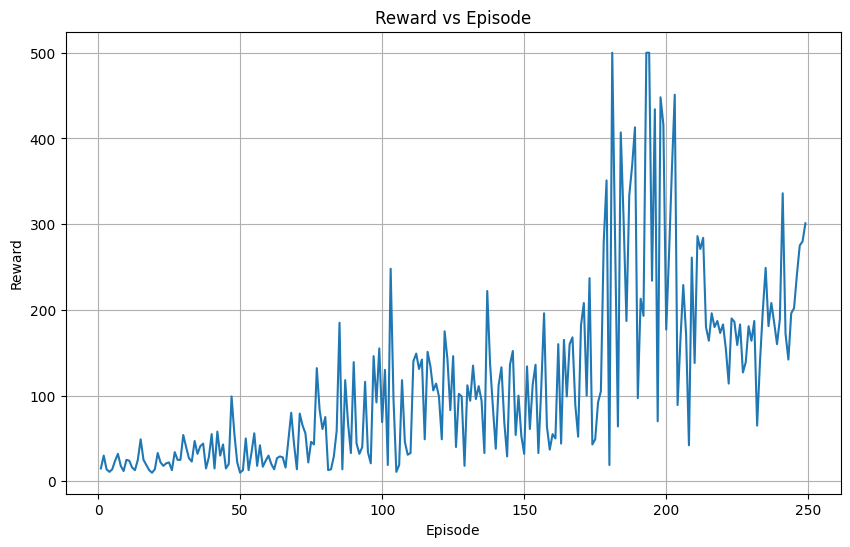

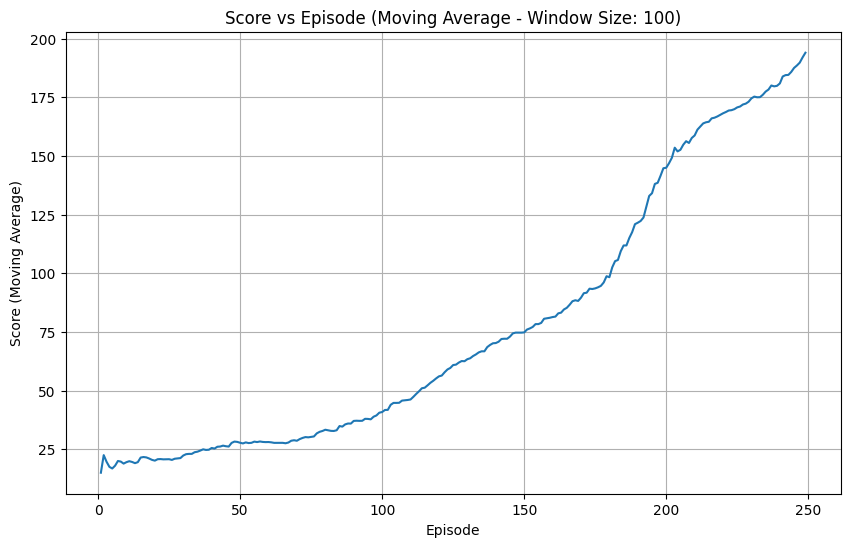

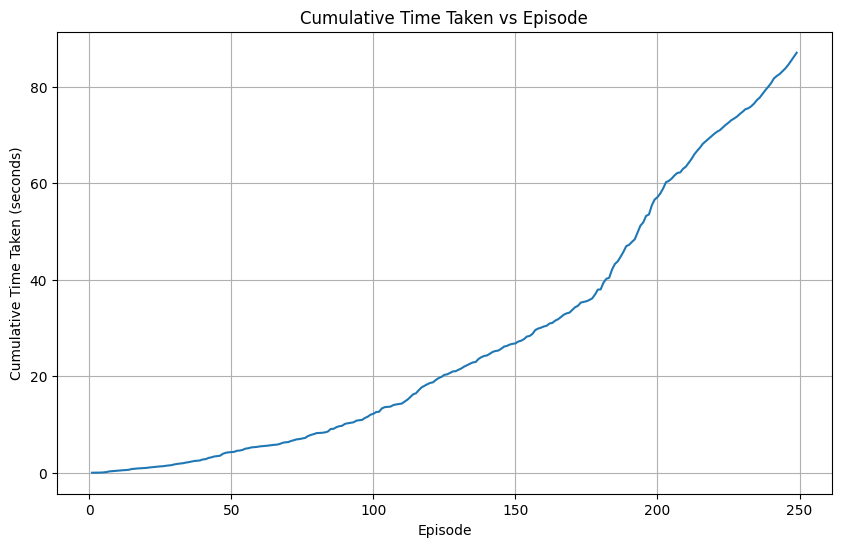

In [8]:
''' Defining DQN Algorithm '''

state_shape = env.observation_space.shape[0]
action_shape = env.action_space.n


class DQN:
    def __init__(self):
        self.episode_count = 0
        self.episode_times = []
        self.episode_rewards = []

    def dqn(self, env, agent, n_episodes=10000, max_t=1000, policy=None, param_start=1.0, param_end=0.01, param_decay=0.995):

        scores_window = deque(maxlen=100)
        ''' last 100 scores for checking if the avg is more than 195 '''

        param = param_start
        ''' initialize the parameter '''

        self.episode_count = 0
        start_time = datetime.datetime.now()

        for i_episode in range(1, n_episodes+1):
            state = env.reset()
            score = 0
            for t in range(max_t):
                action = agent.act(state, eps=param, tau=param, policy=policy)
                next_state, reward, done, _ = env.step(action)
                agent.step(state, action, reward, next_state, done)

                state = next_state
                score += reward

                if done:
                    break
            episode_time = (datetime.datetime.now() - start_time).total_seconds()
            self.episode_times.append(episode_time)

            scores_window.append(score)
            self.episode_rewards.append(score)

            param = max(param_end, param_decay *param)
            ''' decrease the parameter '''

            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

            if i_episode % 100 == 0:
              print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))

            if np.mean(scores_window)>=195.0:
              print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
              self.episode_count = i_episode
              break

        return True

    def plot_reward_vs_episode(self, episode_rewards):
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(episode_rewards) + 1), episode_rewards)
        plt.title('Reward vs Episode')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.grid(True)
        plt.show()

    def plot_score_vs_episode(self, episode_rewards, window_size=100):
        scores = [np.mean(episode_rewards[max(0, i - window_size):i + 1]) for i in range(len(episode_rewards))]
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(scores) + 1), scores)
        plt.title(f'Score vs Episode (Moving Average - Window Size: {window_size})')
        plt.xlabel('Episode')
        plt.ylabel('Score (Moving Average)')
        plt.grid(True)
        plt.show()

    def plot_time_taken_vs_episode(self, time_taken):
        plt.figure(figsize=(10, 6))
        plt.plot(np.arange(1, len(self.episode_times) + 1), self.episode_times)
        plt.title('Cumulative Time Taken vs Episode')
        plt.xlabel('Episode')
        plt.ylabel('Cumulative Time Taken (seconds)')
        plt.grid(True)
        plt.show()

''' Trial run to check if algorithm runs and saves the data '''

begin_time = datetime.datetime.now()
agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)

dqn_ = DQN()
dqn_.dqn(env, agent, policy='epsilon-greedy')

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

dqn_.plot_reward_vs_episode(dqn_.episode_rewards)
dqn_.plot_score_vs_episode(dqn_.episode_rewards)
dqn_.plot_time_taken_vs_episode(dqn_.episode_times)

### **Task 1a**  
Understand the core of the algorithm, follow the flow of data. Identify the exploration strategy used.

Exploration strategy used: $\epsilon -$greedy with a decaying $\epsilon$

### **Task 1b**
Out of the two exploration strategies discussed in class ($ϵ$-greedy & Softmax). Implement the strategy that's not used here.

Episode 99	Average Score: 195.48
Environment solved in 99 episodes!	Average Score: 195.48
0:00:59.304882


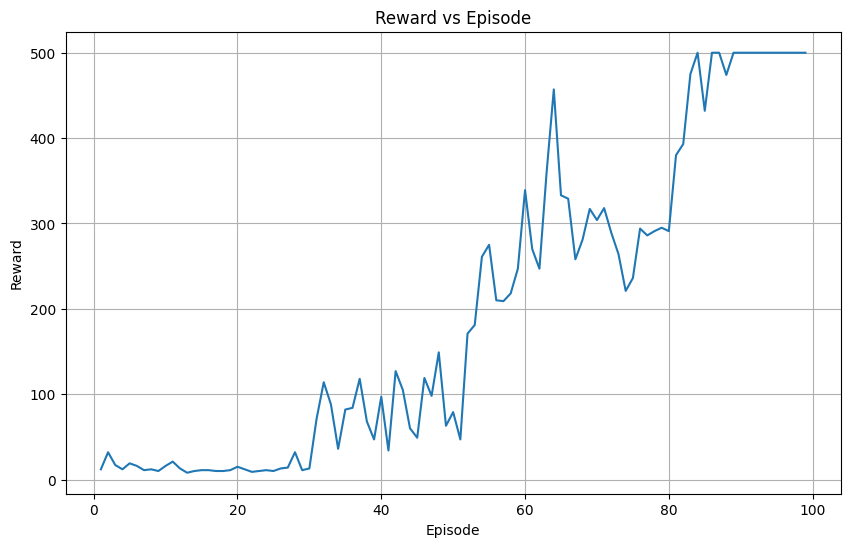

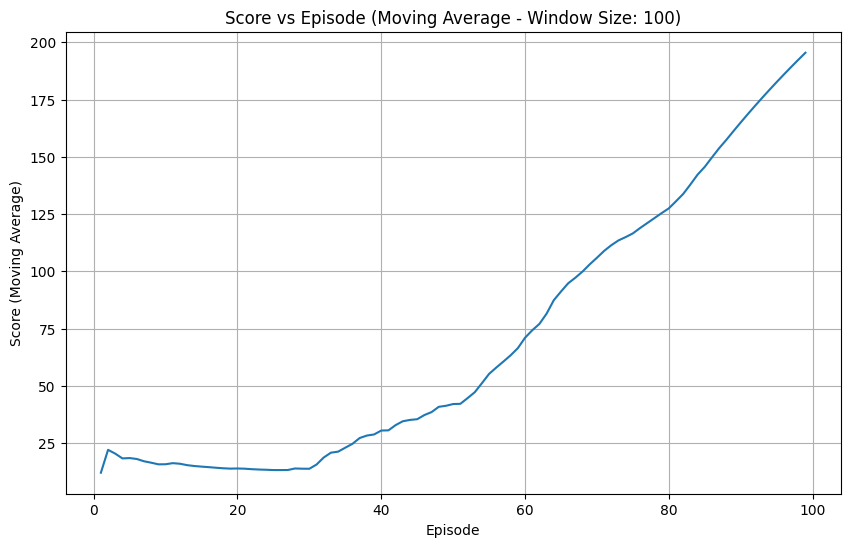

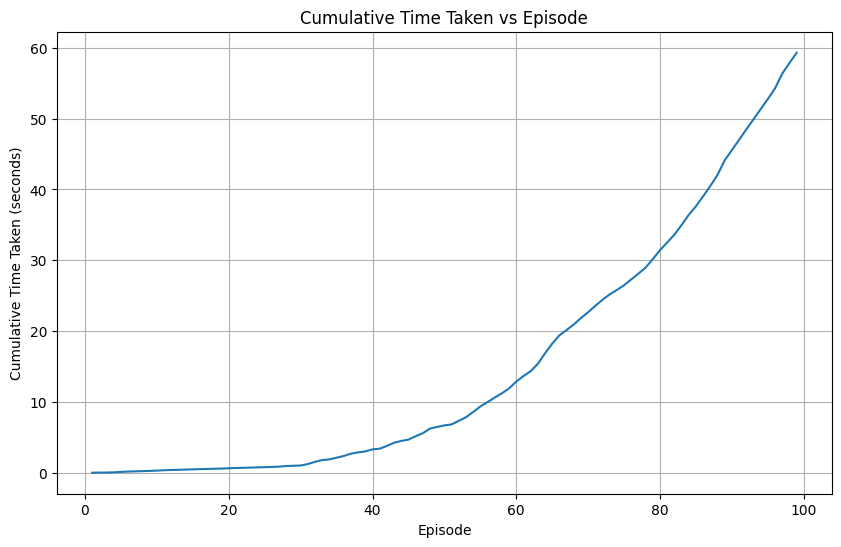

In [9]:
begin_time = datetime.datetime.now()
agent = TutorialAgent(state_size=state_shape,action_size = action_shape,seed = 0)

dqn_ = DQN()
dqn_.dqn(env, agent, policy='softmax')

time_taken = datetime.datetime.now() - begin_time

print(time_taken)

dqn_.plot_reward_vs_episode(dqn_.episode_rewards)
dqn_.plot_score_vs_episode(dqn_.episode_rewards)
dqn_.plot_time_taken_vs_episode(dqn_.episode_times)

### **Task 1c**
How fast does the agent 'solve' the environment in terms of the number of episodes?
(Cartpole-v1 defines "solving" as getting average reward of 195.0 over 100 consecutive trials)

How 'well' does the agent learn? (reward plot?) The above two are some 'evaluation metrics' you can use to comment on the performance of an algorithm.

Please compare DQN (using $\epsilon$-greedy) with DQN (using softmax). Think along the lines of 'no. of episodes', 'reward plots', 'compute time', etc. and add a few comments.





1. Under decaying $\epsilon -$ greedy policy `(start_value = 1.0, end_value = 0.01, decay_parameter = 0.995)`, the agent solves the environmnet in 249 episodes with a computing time of 0:01:27.044289 by acheiving an average reward of 195.45 over 100 consecutive trials; whereas, with the decaysing softmax policy with the precisely same values for the hyperparameter, it solves the environment in just 99 episodes with a computing time of 0:00:59.304882 by acheiving an average reward of 195.48 over 100 consecutive trials. <br/> <br/>
The reader/ evaluator may also note the following: <br/>
In some other instances of the code run of the exact same parameters, $\epsilon -$ greedy policy makes the agent solve the environment in 1636 episodes with a final (100 episodes) average Score of 196.18 in 0:02:53.820056, whereas the exact same run softmax finishes solving the environment solved in 62 episodes with the respective average Score of 199.48 in just 0:00:23.227403. The data/ output and plots concering this has been attached below. <br />
$\epsilon -$ greedy:
```
Episode 100	Average Score: 38.24
Episode 200	Average Score: 147.36
Episode 300	Average Score: 132.00
Episode 400	Average Score: 29.183
Episode 500	Average Score: 9.990
Episode 600	Average Score: 9.59
Episode 700	Average Score: 16.64
Episode 800	Average Score: 9.481
Episode 900	Average Score: 9.39
Episode 1000	Average Score: 90.59
Episode 1100	Average Score: 19.410
Episode 1200	Average Score: 24.28
Episode 1300	Average Score: 172.40
Episode 1400	Average Score: 39.322
Episode 1500	Average Score: 19.29
Episode 1600	Average Score: 48.82
Episode 1636	Average Score: 196.18
Environment solved in 1636 episodes!	Average Score: 196.18
0:02:53.820056
```
![epsilon-reward](./epsilon-reward.png)

![epsilon-score](./epsilon-score.png)

![epsilon-time](./epsilon-time.png) <br />
Softmax:
```
Episode 62	Average Score: 199.48
Environment solved in 62 episodes!	Average Score: 199.48
0:00:23.227403
```
![softmax-reward](./softmax-reward.png)

![softmax-score](./softmax-score.png)

![softmax-time](./softmax-time.png)

The reason might be that $\epsilon -$ greedy diverged from the nearby local optimium and somehow, it got captured by a distance local optimum. The huge spikes at episode 1000, 1200, 1400 and 1600 speaks on this behalf.

2. The instantenous reward vs episode plot is quite stochastic and full of spikes in $\epsilon -$ greedy policy, whereas the same plot in Softmax policy is relatively smoother. Although, we may observe that the overall nature of the plot of score (average reward over 100 consecutive episodes) vs epsidoes is quite similar. There are two inferences:
  *   **Unstable learning:** Too many spikes in the instantenous reward vs episodes plot in $\epsilon -$ greedy policy suggests that the agent's learning process is unstable. The agent might struggle to converge to a consistent and optimal policy, leading to frequent fluctuations in its performance.
  *   **Exploration- exploitation trade-off:** Softmax, on the other hand, shows relative stable and steady learning. The agent shows an optimum balance of exploration and exploitation and does not hallucinate. As a result, whether it is the instantenous reward curve or the average reward curve, we see relative smoothness and fastness in the plot of softmax.

3. Now, coming to the no. of episodes problem. Yes, softmax performs at least twice better than $\epsilon -$ greedy, solves at least twice faster, learns at least twice smoother and uses at least twice less computing time than $\epsilon -$ greedy. These can be described as follows:
  * **Method:** Epsilon-greedy exploration involves randomly selecting an action with probability epsilon, which can lead to more random and less focused exploration. On the other hand, Softmax has a more adaptive exploration strategy as the temperature parameter allows for a smooth transition from exploration to exploitation.
  * **Algorithmic complexity:** The underlying algorithmic complexity of the epsilon-greedy strategy, especially in the presence of a decaying epsilon schedule, can contribute to variations in the learning time.
  * **Tuning errors:** One more possiblity is that may be it has not been tuned properly wrt the values concering $\epsilon -$ greedy. Fortunately enough, the exact same parameter values generates better results in case of Softmax.

4. Last but not the least, the computing time. Obviously enough, the computing time $\varpropto$ F(no of episodes), where $F$ can be any montonically increasing function (suggesting non-linearity). Hence all the reasons that are appilcable for Softmax consuming lesser number of episodes are applicable here as well. One interesting thing is to comapre the average computing time per a single episode, which is 0.34957545783 seconds/ episode for $\epsilon -$ greedy and 0.59903921212 seconds/ episode for softmax. This is an interesting behaviour as Softmax on average is taking twice computing time per episode than $\epsilon -$ greedy.$^1$ The reasons mightbe as follows:
  * **Computational complexity:** The softmax function involves exponentiation and normalization, which can be computationally more expensive compared to the simple probability-based decision-making in epsilon-greedy. On the otherhand, $\epsilon -$ greedy is much simpler from implementation, usage and computational point of view.
  * **Temperature parameter:** The softmax function includes a temperature parameter that determines the level of exploration. If the temperature is set too high, softmax might require more computations to compute probabilities accurately.
  * **Exploration intensity:** Depending on the temperature parameter and exploration strategy, softmax might engage in more intense exploration, leading to more evaluations of the softmax function and potentially higher computational time.

<hr />

$^1$ Here we are not comparing the computational aspect concering the second run, where the $\epsilon -$ greedy took $\geqslant$ 1600 episodes, as it seems to escape a local convering point and fell in to a nearby optimum point, on the other hand Softmax converged towards the nearby optimum point. Hence the computational comparison does not fair enough in that instance of the test.

#### **Submission Steps**

#### Task 1: Add a text cell with the answer.

#### Task 2: Add a code cell below task 1 solution and use 'Tutorial Agent Code' to build your new agent (with a different exploration strategy).

#### Task 3: Add a code cell below task 2 solution running both the agents to solve the CartPole v-1 environment and add a new text cell below it with your inferences.